### Libraries

In [1]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import numpy as np
import pandas as pd
import random
import sklearn
import time
import matplotlib.pyplot as plt
import os
import sys

from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
from tqdm import tqdm
from utils import *

In [2]:
# ensure reproducibilities
seed = False
if seed:
    SEED = 3
    
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True

In [3]:
robot_choice = "3DoF-R"
if robot_choice == "3DoF-R":
    n_DoF = 3
    input_dim = 2
    output_dim = 3
data = pd.read_csv('data_'+robot_choice+'.csv')
data

,x,y,t1,t2,t3
0,0.908878,0.972347,-0.023520,1.685287,-2.585673
1,-1.603698,-0.366326,-2.312021,-1.209998,0.842441
2,0.241596,0.591827,-0.062245,2.490936,-0.278798
3,1.666944,0.620960,0.831305,-0.949430,-0.617528
4,-0.628984,0.792674,-3.001316,-2.080621,-1.295037
...,...,...,...,...,...
9995,0.066960,-0.313310,0.049666,-2.819821,-2.962427
9996,1.448904,-0.102334,-0.828447,1.515872,0.478921
9997,0.289784,0.069563,1.656825,-2.842462,-2.148063
9998,0.558301,-1.918480,-1.243619,-0.087972,1.720874


[Text(0.5, 0, 'x(m)'), Text(0, 0.5, 'y(m)'), Text(0.5, 1.0, 'theta 3')]

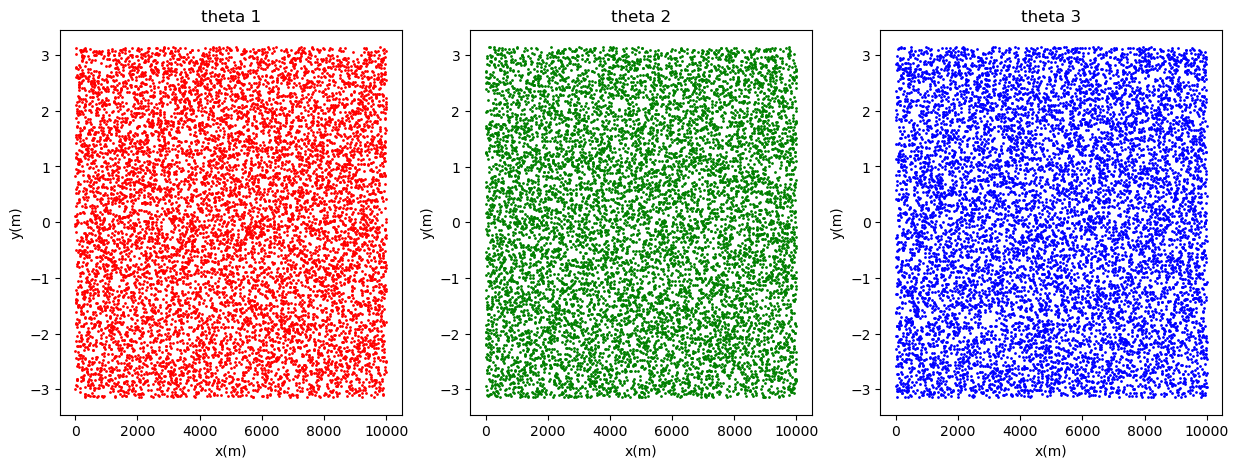

In [4]:
# visualize joints
data_a = np.array(data) 
n_samples = data_a.shape[0]
values = np.linspace(1,n_samples,n_samples)

fig, axs = plt.subplots(1,3, figsize=(15, 5)) #, sharex=True, sharey=True)
axs[0].scatter(values, data_a[:,2],s=1, marker='o', c='r')
axs[0].set(xlabel='x(m)', ylabel='y(m)', title='theta 1')
axs[1].scatter(values, data_a[:,3],s=1, marker='o', c='g')
axs[1].set(xlabel='x(m)', ylabel='y(m)', title='theta 2')
axs[2].scatter(values, data_a[:,4],s=1, marker='o', c='b')
axs[2].set(xlabel='x(m)', ylabel='y(m)', title='theta 3')


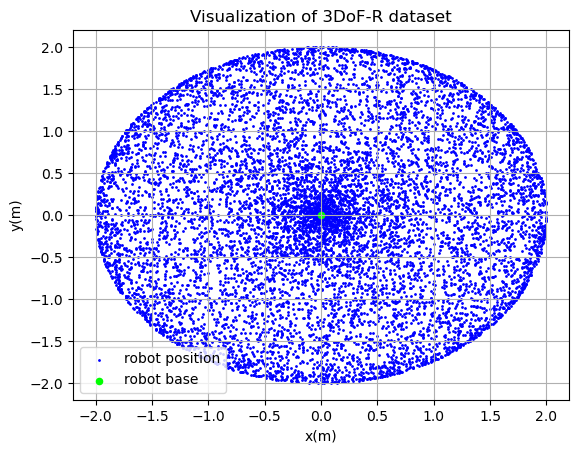

In [5]:
# visualize workspace
fig, ax = plt.subplots()
ax.scatter(data_a[:,0], data_a[:,1],s=1, marker='o', c='b')
ax.scatter(0,0,s=20, marker='o', c='lime')
ax.set(xlabel='x(m)', ylabel='y(m)',
       title='Visualization of '+robot_choice+ ' dataset')
ax.legend(["robot position","robot base"])
ax.grid()

In [6]:
# vanilla MLP architecture
class MLP_2(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.name = "MLP[]"
        self.input_fc = nn.Linear(input_dim, 250)
        self.hidden_fc = nn.Linear(250, 100)
        self.output_fc = nn.Linear(100, output_dim)

    def forward(self, x):

        # x = [batch size, height, width]
        batch_size = x.shape[0]
        
        x = x.view(batch_size, -1)
        # x = [batch size, height * width]
        
        h_1 = F.relu(self.input_fc(x))
        # h_1 = [batch size, 250]

        h_2 = F.relu(self.hidden_fc(h_1))
        # h_2 = [batch size, 100]

        y_pred = self.output_fc(h_2)
        # y_pred = [batch size, output dim]

        return y_pred, h_2

class MLP(nn.Module):
    def __init__(self, input_dim, h_sizes, output_dim):
        super().__init__()

        self.name = "MLP [{}, {}, {}]".format(str(input_dim), str(h_sizes).replace("[","").replace("]",""), str(output_dim))
        self.input_dim = input_dim
        self.h_sizes = h_sizes
        self.output_dim = output_dim
        
        self.input_fc = nn.Linear(self.input_dim, self.h_sizes[0])
        
        self.hidden_fc = nn.ModuleList()
        for i in range(len(self.h_sizes)-1):
            self.hidden_fc.append(nn.Linear(self.h_sizes[i], self.h_sizes[i+1]))
        
        self.output_fc = nn.Linear(self.h_sizes[len(self.h_sizes)-1], output_dim)

        self.selu_activation = nn.SELU()
        self.relu_activation = nn.ReLU()
        self.prelu_activation = nn.PReLU()
        self.lrelu_activation = nn.LeakyReLU()
        self.sigmoid_activation = nn.Sigmoid()
        self.batch_norm_fc = nn.BatchNorm1d(20000)

    def forward(self, x):

        x = self.input_fc(x)
        #x = self.batch_norm_fc(x)
        x = self.relu_activation(x)  # ReLU(), Sigmoid(), LeakyReLU(negative_slope=0.1)

        for i in range(len(self.h_sizes)-1):
            x = self.hidden_fc[i](x)
            #x = self.batch_norm_fc(x)
            x = self.relu_activation(x)

        x = self.output_fc(x)
        x_temp = x

        return x, x_temp 


# count network parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# data loader
class LoadIKDataset(Dataset):
    def __init__(self, inputs_array, outputs_array):
        x_temp = inputs_array
        y_temp = outputs_array

        self.x_data = torch.tensor(x_temp, dtype=torch.float32) 
        self.y_data = torch.tensor(y_temp, dtype=torch.float32) 

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        current_input = self.x_data[idx, :]
        current_output = self.y_data[idx, :]
        
        sample = {'input': current_input,
                  'output': current_output}
        return sample
    

    def __len__(self):
        return len(self.x_data)


# function to load the dataset
def load_dataset(data, n_DoF, batch_size):
    
    X = data[:,:2]
    y = data[:,2:]

        
    #y = data[:,:2]
    #X = data[:,2:]
        
    # split in train and test sets
    X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(X, 
                                                                y, 
                                                                test_size = 0.1,
                                                                random_state = 1)

    sc_in = MinMaxScaler(copy=True, feature_range=(-1, 1))
    sc_out = MinMaxScaler(copy=True, feature_range=(-1, 1))
    
    X_train = sc_in.fit_transform(X_train_i)
    X_test = sc_in.transform(X_test_i)  

    #y_train = sc_out.fit_transform(y_train)
    #y_test = sc_out.transform(y_test) 

    print(X_train.shape)
    print(y_train_i.shape)

    train_data = LoadIKDataset(X_train, y_train_i)
    test_data = LoadIKDataset(X_test, y_test_i)

    train_data_loader = DataLoader(dataset=train_data,
                                   batch_size=batch_size,
                                   shuffle=False,
                                   drop_last=False)

    test_data_loader = DataLoader(dataset=test_data,
                                   batch_size=1,
                                   shuffle=False)

    return train_data_loader, test_data_loader, X_test_i, y_test_i, X_train, y_train_i

# train function
def train(model, iterator, optimizer, criterion, batch_size, device, epoch, EPOCHS):
    epoch_loss = 0
    model.train()
    i = 0
    
    #with tqdm(total=(len(iterator) - len(iterator) % batch_size)) as t:
    with tqdm(total=len(iterator), desc='Epoch: [{}/{}]'.format(epoch+1, EPOCHS), disable=True) as t:
        for data in iterator:
        #for data in tqdm(iterator, desc="Training", leave=False):
            optimizer.zero_grad()
            x, y = data['input'], data['output']
            #print(x)
            #print(y)
            x = x.to(device)
            y = y.to(device)
            y_pred, _ = model(x)
            """
            if i == 1:
                print("\nTrain Epoch {} at batch {}".format(epoch, i))
                print(y_pred[:5,:])
                print(y[:5,:])
                #sys.exit()
            """
            optimizer.zero_grad()
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            t.set_postfix_str('Train loss: {:.6f}'.format(epoch_loss/len(iterator)))
            t.update()

            i += 1
    
    
    
    #print("Total batches {}".format(i))
        
    return epoch_loss/len(iterator)

# evaluation function 
def evaluate(model, iterator, criterion, device, epoch, EPOCHS):
    epoch_loss = 0
    model.eval()
    
    with torch.no_grad():
        #for data in tqdm(iterator, desc="Evaluating", leave=False):        
        with tqdm(total=len(iterator), desc='Epoch: [{}/{}]'.format(epoch+1, EPOCHS), disable=True) as t:
            for data in iterator:
                x = data['input'].to(device)
                y = data['output'].to(device)
                y_pred, _ = model(x)
                loss = criterion(y_pred, y)
                epoch_loss += loss.item()
    
                t.set_postfix_str('Valid loss: {:.6f}'.format(epoch_loss/len(iterator)))
                t.update()

    return epoch_loss/len(iterator)

# make predictions
def inference(model, iterator, criterion, device):
    model.eval()
    y_preds = []
    y_desireds = []
    X_desireds = []
    for data in iterator:
        x = data['input'].to(device)
        y = data['output'].to(device)
        y_pred, _ = model(x)
        y_preds.append(y_pred.detach().cpu().numpy().squeeze())
        y_desireds.append(y.detach().cpu().numpy().squeeze())
        #X_desireds.append(x.detach().cpu().numpy().squeeze())

    y_desireds = np.array(y_desireds)
    #X_desireds = np.array(X_desireds)
    X_desireds = reconstruct_pose(y_desireds, robot_choice)
    y_preds = np.array(y_preds)
    X_preds = reconstruct_pose(y_preds, robot_choice)

    X_errors = np.abs(X_preds- X_desireds)
    y_errors = np.abs(y_preds- y_desireds)

    X_errors_report = np.array([[X_errors.min(axis=0)],
                                [X_errors.mean(axis=0)],
                                [X_errors.max(axis=0)]]).squeeze()
    
    results = {
        "y_preds": y_preds,
        "X_preds": X_preds,
        "y_desireds": y_desireds,
        "X_desireds": X_desireds,
        "X_errors": X_errors_report
    }
    return results

def inference_FK(model, iterator, criterion, device):
    model.eval()
    y_preds = []
    y_desireds = []
    X_desireds = []
    for data in iterator:
        x = data['input'].to(device)
        y = data['output'].to(device)
        y_pred, _ = model(x)
        y_preds.append(y_pred.detach().cpu().numpy().squeeze())
        y_desireds.append(y.detach().cpu().numpy().squeeze())
        X_desireds.append(x.detach().cpu().numpy().squeeze())

    y_desireds = np.array(y_desireds)
    X_desireds = np.array(X_desireds)
    #X_desireds = reconstruct_pose(y_desireds, robot_choice)
    y_preds = np.array(y_preds)
    #X_preds = reconstruct_pose(y_preds, robot_choice)

    #X_errors = np.abs(X_preds - X_desireds)
    y_errors = np.abs(y_preds - y_desireds)

    y_errors_report = np.array([[y_errors.min(axis=0)],
                                [y_errors.mean(axis=0)],
                                [y_errors.max(axis=0)]]).squeeze()
    
    results = {
        "y_preds": y_preds,
        #"X_preds": X_preds,
        "y_desireds": y_desireds,
        #"X_desireds": X_desireds,
        "y_errors": y_errors_report
    }
    return results

# reconstruct positions in cartesian space from predictions
def reconstruct_pose(y_preds, robot_choice):
    y_preds = torch.from_numpy(y_preds)
    n_samples = y_preds.shape[0]
    pose = []
    for i in range(n_samples):
        t = y_preds[i,:]
        DH = get_DH(robot_choice, t)
        T = forward_kinematics(DH)
        if robot_choice == "3DoF-R":
            # x,y,t1,t2,t3 where x,y (m) and t (rad)
            pose.append(T[:2,-1].numpy())
          
    X_pred = np.array(pose)
    return X_pred
    

# compute epoch time
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


In [7]:
# fetch the device to train on
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# get data loaders
batch_size = 16
train_data_loader, test_data_loader, X_test, y_test, X_train, y_train = load_dataset(data_a, n_DoF, batch_size)

# architecture to employ
init_type = "default" # default, uniform, normal, xavier_uniform, xavier_normal
hidden_layer_sizes = [50,50]
hidden_layer_sizes = [32,64,128,32]

# get network architecture
model = MLP(input_dim, hidden_layer_sizes, output_dim)

if init_type == "uniform":
    model.apply(weights_init_uniform_rule)
elif init_type == "normal":
    model.apply(weights_init_normal_rule)
elif init_type == "xavier_uniform":
    model.apply(weights_init_xavier_uniform_rule)
elif init_type == "xavier_normal":
    model.apply(weights_init_xavier_normal_rule)
elif init_type == "kaiming_uniform":
    model.apply(weights_init_kaiming_uniform_rule)
elif init_type == "kaiming_normal":
    model.apply(weights_init_kaiming_normal_rule)
    
model = model.to(device)
print("==> Architecture: {}\n{}".format(model.name, model))
print("==> Trainable parameters: {}".format(count_parameters(model)))

(9000, 2)
(9000, 3)
==> Architecture: MLP [2, 32, 64, 128, 32, 3]
MLP(
  (input_fc): Linear(in_features=2, out_features=32, bias=True)
  (hidden_fc): ModuleList(
    (0): Linear(in_features=32, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=32, bias=True)
  )
  (output_fc): Linear(in_features=32, out_features=3, bias=True)
  (selu_activation): SELU()
  (relu_activation): ReLU()
  (prelu_activation): PReLU(num_parameters=1)
  (lrelu_activation): LeakyReLU(negative_slope=0.01)
  (sigmoid_activation): Sigmoid()
  (batch_norm_fc): BatchNorm1d(20000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
==> Trainable parameters: 54756


In [8]:
## train and validate

# create a directory to save weights
save_path = "weights"
if not os.path.exists(save_path):
    os.makedirs(save_path)

# set the optimizers
learning_rate = 1e-4
#optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999))
optimizer_choice = "RMSprop" #SGD, Adam, Adadelta, RMSprop

if optimizer_choice == "SGD":
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
elif optimizer_choice == "Adam":
    optimizer = optim.Adam(model.parameters())
elif optimizer_choice == "Adadelta":
    optimizer = optim.Adadelta(model.parameters())
elif optimizer_choice == "RMSprop":
    optimizer = optim.RMSprop(model.parameters())
    
criterion = nn.MSELoss(reduction="mean") # nn.MSELoss(), nn.L1Loss()

# define epoch
EPOCHS = 100
best_valid_loss = float('inf')


print("\n==> Training network: {}".format(model.name))

train_losses = []
valid_losses = []
start_time_train = time.monotonic()
for epoch in range(EPOCHS):
    
    start_time = time.monotonic()
    train_loss = train(model, train_data_loader, optimizer, criterion, batch_size, device, epoch, EPOCHS)        
    valid_loss = evaluate(model, test_data_loader, criterion, device, epoch, EPOCHS)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), save_path+'/best_epoch.pth')
        best_epoch = epoch
    
    end_time = time.monotonic()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if epoch % (EPOCHS/10) == 0 or epoch == EPOCHS-1:
        print('Epoch: {}/{} | Epoch Time: {}m {}s'.format(epoch, EPOCHS, epoch_mins, epoch_secs))
        print('\tTrain Loss: {}'.format(train_loss))
        print('\tValid Loss: {}'.format(valid_loss))
        print("\tBest Epoch Occurred [{}/{}]".format(best_epoch, EPOCHS))
        torch.save(model.state_dict(), save_path+'/epoch_'+str(epoch)+'.pth')

end_time_train = time.monotonic()
epoch_mins, epoch_secs = epoch_time(start_time_train, end_time_train)
print('\nElapsed Time: {}m {}s'.format(epoch_mins, epoch_secs))    


==> Training network: MLP [2, 32, 64, 128, 32, 3]
Epoch: 0/100 | Epoch Time: 0m 1s
	Train Loss: 2.989919353971261
	Valid Loss: 2.894964358612895
	Best Epoch Occurred [0/100]
Epoch: 10/100 | Epoch Time: 0m 0s
	Train Loss: 2.824907027383469
	Valid Loss: 2.811359589803964
	Best Epoch Occurred [7/100]
Epoch: 20/100 | Epoch Time: 0m 0s
	Train Loss: 2.814951060296799
	Valid Loss: 2.8382956192139535
	Best Epoch Occurred [7/100]
Epoch: 30/100 | Epoch Time: 0m 0s
	Train Loss: 2.808810629175569
	Valid Loss: 2.8241186758466066
	Best Epoch Occurred [26/100]
Epoch: 40/100 | Epoch Time: 0m 0s
	Train Loss: 2.8120973781412912
	Valid Loss: 2.784353400258347
	Best Epoch Occurred [31/100]
Epoch: 50/100 | Epoch Time: 0m 0s
	Train Loss: 2.813473261270811
	Valid Loss: 2.802782587926835
	Best Epoch Occurred [31/100]
Epoch: 60/100 | Epoch Time: 0m 0s
	Train Loss: 2.8069505890563367
	Valid Loss: 2.7815259200185536
	Best Epoch Occurred [31/100]
Epoch: 70/100 | Epoch Time: 0m 0s
	Train Loss: 2.7975489798913418


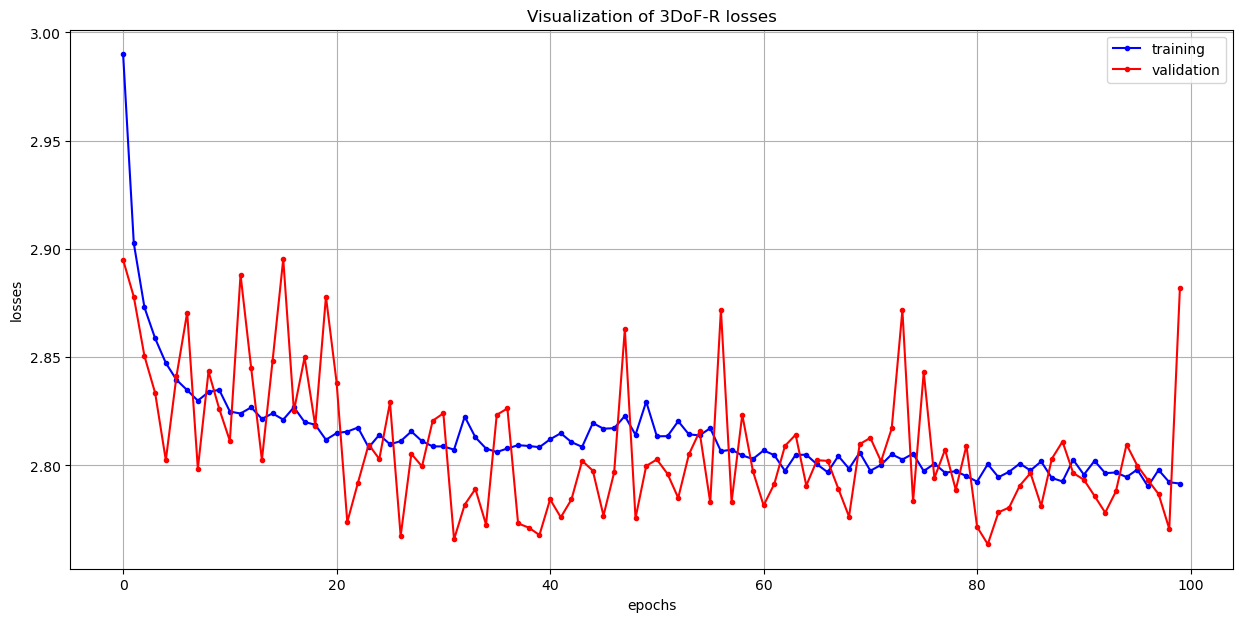

In [9]:
# visualize losses
train_losses = np.array(train_losses)
valid_losses = np.array(valid_losses)

fig, ax = plt.subplots(figsize=(15,7))
ax.plot(train_losses, marker='.', c='b')
ax.plot(valid_losses, marker='.', c='r')
ax.set(xlabel='epochs', ylabel='losses',
       title='Visualization of '+robot_choice+ ' losses')
ax.legend(["training", "validation"])
ax.grid()

In [10]:
# inference
weights_file = "weights/best_epoch.pth"
model = MLP(input_dim, hidden_layer_sizes, output_dim).to(device)

state_dict = model.state_dict()
for n, p in torch.load(weights_file, map_location=lambda storage, loc: storage).items():
    if n in state_dict.keys():
        state_dict[n].copy_(p)
    else:
        raise KeyError(n)

# get the results from training

results = inference(model, test_data_loader, criterion, device)
y_preds = results["y_preds"]
X_preds = results["X_preds"]
y_desireds = results["y_desireds"]
X_desireds = results["X_desireds"]
X_errors = results["X_errors"]

print("==> y_preds {}: min = {:.4f} / mean = {:.4f} / max = {:.4f}\n{}\n".format(y_preds.shape, y_preds.min(), y_preds.mean(), y_preds.max(), y_preds))
print("==> y_test {}: min = {:.4f} / mean = {:.4f} / max = {:.4f}\n{}\n".format(y_test.shape, y_test.min(), y_test.mean(), y_test.max(), y_test))

print("==> X_preds {}: min = {:.4f} / mean = {:.4f} / max = {:.4f}\n{}\n".format(X_preds.shape, X_preds.min(), X_preds.mean(), X_preds.max(), X_preds))
print("==> X_test {}: min = {:.4f} / mean = {:.4f} / max = {:.4f}\n{}\n".format(X_test.shape, X_test.min(), X_test.mean(), X_test.max(), X_test))
print("X_errors (mm): \n{}".format(X_errors*1000))
"""

results = inference_FK(model, test_data_loader, criterion, device)
y_preds = results["y_preds"]
y_desireds = results["y_desireds"]
y_errors = results["y_errors"]

print("==> y_preds {}: min = {:.4f} / mean = {:.4f} / max = {:.4f}\n{}\n".format(y_preds.shape, y_preds.min(), y_preds.mean(), y_preds.max(), y_preds))
print("==> y_test {}: min = {:.4f} / mean = {:.4f} / max = {:.4f}\n{}\n".format(y_test.shape, y_test.min(), y_test.mean(), y_test.max(), y_test))
print("y_errors (mm): \n{}".format(y_errors*1000))
"""

==> y_preds (1000, 3): min = -3.1359 / mean = -0.0295 / max = 2.9161
[[-0.65909386  0.08453862 -0.01180358]
 [ 0.6739402  -0.09488296  0.02421256]
 [ 0.29726198 -0.09933553  0.09048778]
 ...
 [-0.801497   -0.01374103  0.01508062]
 [ 0.83847666 -0.09293803 -0.00473706]
 [ 0.91646314 -0.09201618 -0.0184585 ]]

==> y_test (1000, 3): min = -3.1415 / mean = 0.0691 / max = 3.1406
[[ 1.6907732   1.4716241  -0.01993918]
 [ 2.8537996   1.7119834   0.971514  ]
 [-0.88448787  2.328623    0.62574506]
 ...
 [-1.9518262   2.9402964  -0.18664312]
 [-0.9426489   2.8490722   1.8345349 ]
 [ 0.14915204  2.932347    2.2428415 ]]

==> X_preds (1000, 2): min = -1.9994 / mean = 0.4425 / max = 1.9989
[[ 1.6299816  -1.1558623 ]
 [ 1.6183478   1.1713047 ]
 [ 1.9366186   0.48954004]
 ...
 [ 1.3813272  -1.4462869 ]
 [ 1.403319    1.4219931 ]
 [ 1.2875934   1.5276263 ]]

==> X_test (1000, 2): min = -1.9996 / mean = 0.0383 / max = 1.9976
[[-1.119473    0.97200817]
 [-1.104954   -0.7054359 ]
 [ 0.7600085   0.2183986

'\n\nresults = inference_FK(model, test_data_loader, criterion, device)\ny_preds = results["y_preds"]\ny_desireds = results["y_desireds"]\ny_errors = results["y_errors"]\n\nprint("==> y_preds {}: min = {:.4f} / mean = {:.4f} / max = {:.4f}\n{}\n".format(y_preds.shape, y_preds.min(), y_preds.mean(), y_preds.max(), y_preds))\nprint("==> y_test {}: min = {:.4f} / mean = {:.4f} / max = {:.4f}\n{}\n".format(y_test.shape, y_test.min(), y_test.mean(), y_test.max(), y_test))\nprint("y_errors (mm): \n{}".format(y_errors*1000))\n'

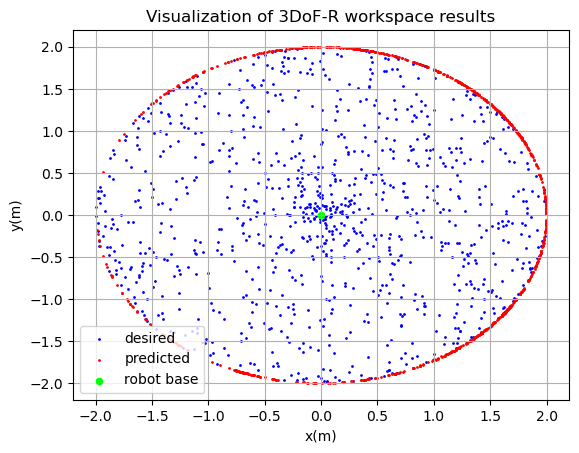

In [11]:
# visualize workspace
fig, ax = plt.subplots()
ax.scatter(X_desireds[:,0], X_desireds[:,1],s=1, marker='o', c='b')
ax.scatter(X_preds[:,0], X_preds[:,1],s=1, marker='o', c='r')
ax.scatter(0,0,s=20, marker='o', c='lime')
ax.set(xlabel='x(m)', ylabel='y(m)',
       title='Visualization of '+robot_choice+ ' workspace results')
ax.legend(["desired", "predicted","robot base"])
ax.grid()

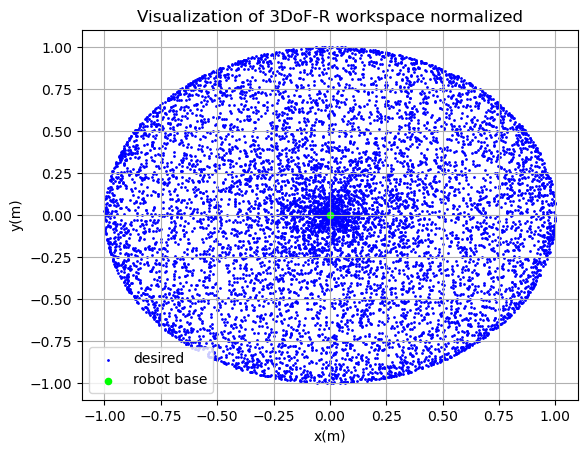

In [12]:
# visualize workspace
fig, ax = plt.subplots()
ax.scatter(X_train[:,0], X_train[:,1],s=1, marker='o', c='b')
ax.scatter(0,0,s=20, marker='o', c='lime')
ax.set(xlabel='x(m)', ylabel='y(m)',
       title='Visualization of '+robot_choice+ ' workspace normalized')
ax.legend(["desired","robot base"])
ax.grid()